In [1]:
import os
import sys
import json
import time
import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from scipy import signal, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

In [4]:
%matplotlib notebook

In [5]:
plt.rcParams.update({'font.size': 12})

Load CCF for identifying cortical areas

#### Functions

In [6]:
def get_zscore_fr(trig_FR, time_bins):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
#     trig_Z = np.zeros_like(trig_FR) # try zeros
    baseline_bins = time_bins < 0
    baseline_avg = np.mean(trig_FR[:,baseline_bins[:-1]], axis=1)
    baseline_std = np.std(trig_FR[:,baseline_bins[:-1]], axis=1)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[nonzero_inds,:] = (trig_FR[nonzero_inds,:] - baseline_avg[nonzero_inds,None]) / baseline_std[nonzero_inds,None]
    
    return trig_Z, nonzero_inds

### Define data path

In [7]:
rec_folder = r'F:\EEG_exp\mouse569065\pilot1_tipref_2021-05-21_12-27-05\Record Node 102\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

This data does not contain an EEG recording.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Body camera file not found.
Pupil camera file not found.


In [8]:
# Make a folder in my OneDrive to save plots
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

In [16]:
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+19:exp.experiment_folder.find('mouse')+25]
print(exp_tag)

tipref


#### Load stim table

In [10]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep
0,sine_140Hz,5,349.63525,359.63131,9.99606,0
1,sine_140Hz,5,369.63136,379.62742,9.99606,0
2,sine_140Hz,5,389.62747,399.62353,9.99606,0
3,sine_140Hz,5,409.62358,419.61964,9.99606,0
4,sine_140Hz,5,429.61969,439.61574,9.99605,0


#### Load unit data

In [11]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeF']


In [12]:
## List probes: region labels in order from top to bottom ##
regions = {'probeF': 'ACA <---> MOs', 'probeB': 'VM/VAL <---> SSp'}

In [13]:
which_units = 'all' # can choose 'all', 'ctx'

In [14]:
probe_unit_data = {}
total_units = 0
for probei in probe_list:
    print(probei)
    probe_unit_data[probei] = {}
    
    ## Load probe_info.json ##
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    npx_allch = np.array(data['channel']) # this is an array from 0 to 384
    surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
    allch_z = np.array(data['vertical_pos']) # vertical pos of each elec (um), rel to the tip (ch 0 is 20 um from tip)
    ref_mask = np.array(data['mask']) # contains a False for Npx reference channels and "bad chs"
    print(' surface channel: {:d}'.format(surface_ch))
    
    ## Get all ch depths ##
    npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
    probe_unit_data[probei]['ch_depths'] = allch_z[surface_ch] - allch_z
    
    ## Select units and get peak chs ##
    select_units, peak_chs, unit_metrics = exp.get_probe_units(probei)
    print(' unit count: {:d}'.format(len(select_units)))
    
    ## Sort units ##
    all_units = select_units[np.squeeze(np.argsort(peak_chs))]
    all_units_chs = peak_chs[np.squeeze(np.argsort(peak_chs))]
    if 'area' in unit_metrics.columns:
        all_units_areas = unit_metrics.area.values[np.squeeze(np.argsort(peak_chs))]
        probe_unit_data[probei]['areas_assigned'] = True
        if which_units == 'ctx':
            ## determine cortical units ##
            ctx_mask = np.zeros_like(all_units, dtype=bool)
            for uai, areai in enumerate(all_units_areas):
                if areai != 'null':
                    if 315 in str_tree.get_structures_by_acronym([areai])[0]['structure_id_path']:
                        ctx_mask[uai] = True
            probe_unit_data[probei]['units'] = all_units[ctx_mask]
            probe_unit_data[probei]['areas'] = all_units_areas[ctx_mask]
            probe_unit_data[probei]['chs'] = all_units_chs[ctx_mask]
            total_units += len(probe_unit_data[probei]['units'])
        else:
            probe_unit_data[probei]['units'] = all_units
            probe_unit_data[probei]['areas'] = all_units_areas
            probe_unit_data[probei]['chs'] = all_units_chs
            total_units += len(probe_unit_data[probei]['units'])
    else:
        print(' unit metrics file does not have area assignments.')
        probe_unit_data[probei]['areas_assigned'] = False
        probe_unit_data[probei]['units'] = all_units
        probe_unit_data[probei]['chs'] = all_units_chs
        total_units += len(probe_unit_data[probei]['units'])
            
    ## Load spike times and cluster ids ##
    probe_unit_data[probei]['spike_times'] = np.load(exp.ephys_params[probei]['spike_times'])
    probe_unit_data[probei]['spike_clusters'] = np.load(exp.ephys_params[probei]['spike_clusters'])
print('Total unit count: {:d}'.format(total_units))

probeB
 surface channel: 368
 unit count: 195
 unit metrics file does not have area assignments.
probeF
 surface channel: 220
 unit count: 100
 unit metrics file does not have area assignments.
Total unit count: 295


<IPython.core.display.Javascript object>


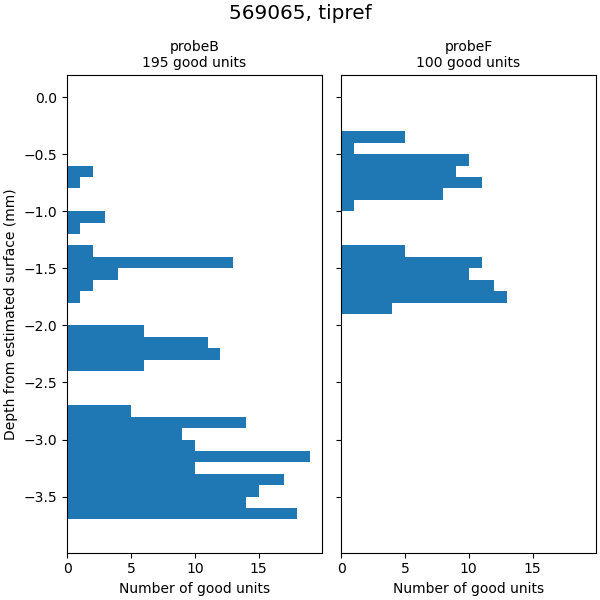

In [17]:
fig, axs = plt.subplots(1, len(probe_list), figsize=(6,6), sharex=True, sharey=True, constrained_layout=True)
depth_bins = np.arange(-3.8, 0.1, 0.1)
for ax, probei in zip(axs.ravel(), probe_list):
    unit_depths = -probe_unit_data[probei]['ch_depths'][probe_unit_data[probei]['chs']]/1000
    ax.hist(unit_depths, bins=depth_bins, orientation='horizontal')
    ax.set_title('{}\n{:d} good units'.format(probei, len(unit_depths)))
    ax.set_xlabel('Number of good units')
axs[0].set_ylabel('Depth from estimated surface (mm)')
plt.suptitle('{}, {}'.format(exp.mouse, exp_tag))

### SAVE ###
figname = '{}_unitcountperdepth.png'.format(exp_tag)
fig.savefig(os.path.join(plotsavedir, figname), transparent=True)

## Average responses

Loop through stimuli, one sweep only

In [18]:
stim_type = 'sine_140Hz' # 'fullscreen', 'auditory', 'biphasic', 'circle'
sweep = 0
# amp_list = np.sort(stim_log[stim_log['stim_type']==stim_type].parameter.unique())
amp_list = sorted(stim_log[stim_log['stim_type']==stim_type].parameter.unique(), key=lambda x: int(x))
print(amp_list)

before_event = 1.0 # time before event, s
after_event = 11.0 # time after event, s

## Unit params ##
plot_timebin = 0.01 # s

[5, 25]


In [19]:
unit_rates = {}
unit_zscores = {}

for ampi in amp_list:
    start = time.time()
    
    ## get events ##
    events = get_stim_events(stim_log, stim_type, ampi, sweep)
    
    ## Units ##
    # get evoked firing rates for all units
    unit_rates[ampi] = {}
    unit_zscores[ampi] = {}
    total_units = 0
    for probei, unit_data in probe_unit_data.items():
        event_trig_FR, spikerate_ts = get_evoked_firing_rates(
            unit_data['spike_times'],
            unit_data['spike_clusters'],
            unit_data['units'],
            events,
            before_event,
            after_event,
            plot_timebin
        )
        # get zscore
        event_trig_Z, non_nan_inds = get_zscore_fr(event_trig_FR, spikerate_ts)

        unit_rates[ampi][probei] = [spikerate_ts, event_trig_FR]
        unit_zscores[ampi][probei] = [spikerate_ts, event_trig_Z]
        total_units += event_trig_FR.shape[1]
    
    end = time.time()
    print('{}: {:.2f} s'.format(ampi, (end - start)))

5: 2.93 s
25: 3.11 s


### Plot all with z-score

<IPython.core.display.Javascript object>


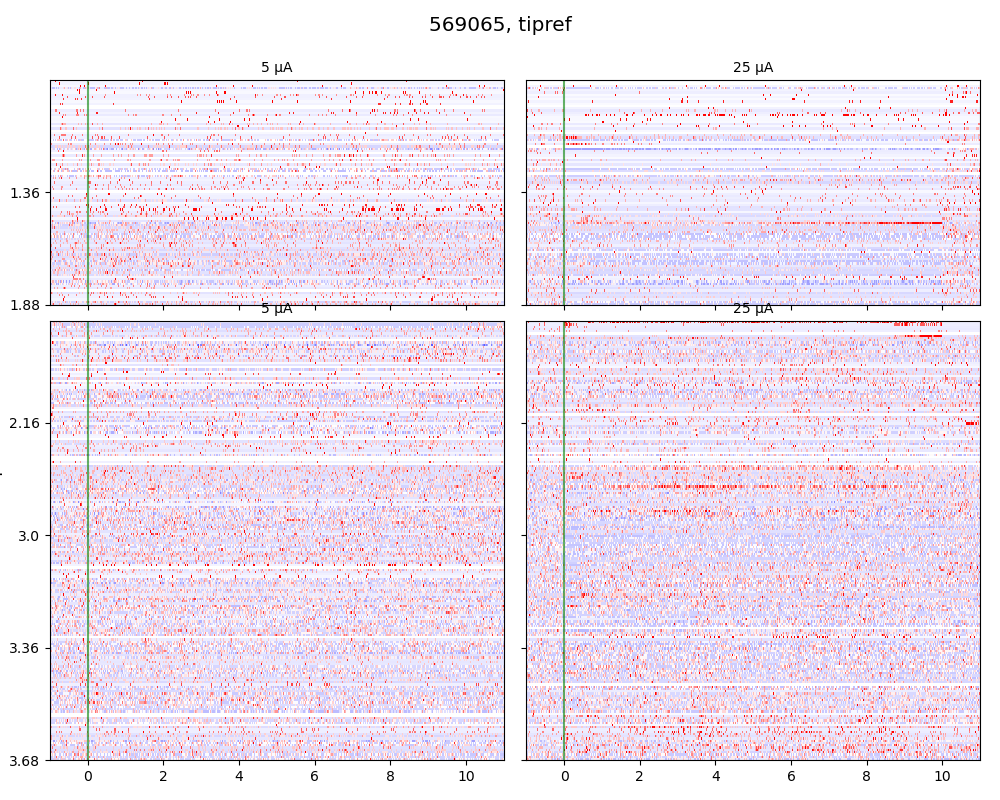

In [20]:
y_limit = 100
set_Zrange = 5

fig = plt.figure(figsize=(10,8)) #, sharex=True, constrained_layout=True)
gs = fig.add_gridspec(
    ncols=(len(amp_list)), nrows=1,
    left=0.05, right=0.98, top=0.9, bottom=0.05, hspace=0.05, wspace=0.05
)

for i, ampi in enumerate(amp_list):

    ## Unit z-score, all probes ##
    gs_units = gs[0,i].subgridspec(
        ncols=1, nrows=len(unit_zscores[ampi].keys()),
        height_ratios=[len(probe_unit_data[x]['units']) for x in regions.keys()], hspace=0.05
    )

    for ii, probei in enumerate(regions.keys()):
        zscoredata = unit_zscores[ampi][probei]
        axzsc = fig.add_subplot(gs_units[ii])
        units_plot = axzsc.imshow(
            zscoredata[1],
            cmap='bwr',
            interpolation='none',
            aspect='auto',
            origin='lower',
            vmin=-set_Zrange,
            vmax=set_Zrange,
            extent=[zscoredata[0][0], zscoredata[0][-1], 0, len(probe_unit_data[probei]['units'])],
        )
        axzsc.axvline(0, color='g', alpha=0.6)
        axzsc.set_title('{} \u03bcA'.format(ampi))
    
        if probe_unit_data[probei]['areas_assigned']:
            if i == 0:
                ## get area labels ##
                area_boundaries = []
                area_labels = []
                last_area = ''
                for ai, area in enumerate(probe_unit_data[probei]['areas']):
                    if area != last_area:
                        area_boundaries.append(ai)
                        area_labels.append(area)
                        last_area = area
                area_boundaries.append(ai)
                label_locs = area_boundaries[:-1] + np.diff(area_boundaries)/2
                axzsc.set_yticks(area_boundaries)
                axzsc.set_yticklabels('')
                axzsc.set_yticks(label_locs, minor=True)
                axzsc.set_yticklabels(area_labels, minor=True, fontsize=8)
                axzsc.tick_params(which='minor', length=0)
            else:
                ## get area labels ##
                area_boundaries = []
                last_area = ''
                for ai, area in enumerate(probe_unit_data[probei]['areas']):
                    if area != last_area:
                        area_boundaries.append(ai)
                        last_area = area
                area_boundaries.append(ai)
                axzsc.set_yticks(area_boundaries)
                axzsc.set_yticklabels('')
        else:
            if i == 0:
                unit_depths = probe_unit_data[probei]['ch_depths'][probe_unit_data[probei]['chs']]
                axzsc.set_yticks(np.arange(0, len(probe_unit_data[probei]['units']), 50))
                axzsc.set_yticklabels(unit_depths[np.arange(0, len(probe_unit_data[probei]['units']), 50)]/1000)
                axzsc.annotate(
                    regions[probei],
                    xy=(-0.12, 0.5),
                    xycoords='axes fraction',
                    horizontalalignment='center',
                    verticalalignment='center',
                    rotation='vertical',
                    fontsize=12
                )
            else:
                axzsc.set_yticks(np.arange(0, len(probe_unit_data[probei]['units']), 50))
                axzsc.set_yticklabels('')
        if ii < len(regions)-1:
            axzsc.set_xticklabels('')
    plt.suptitle('{}, {}'.format(exp.mouse, exp_tag))

### SAVE ###
figname = '{}_{}unitzcore_eeg_allamps_{:d}ms.png'.format(exp_tag, which_units, int(plot_timebin*1000))
# fig.savefig(os.path.join(plotsavedir, figname), transparent=True)

### Plot single trial (stim or spontaneous)

In [21]:
plot_before = 2.0 # time before event, s
plot_after = 12.0 # time after event, s
plot_event = 'stim' # 'spont' or 'stim'

## if plot_event == 'spont'
spont_time = 5671. # time in s to plot around if spont is chosen

## if plot_event == 'stim'
event_ind = 0 # stim_event time to choose, must be integer
stim_type = 'sine_140Hz' # 'fullscreen', 'auditory', 'biphasic'
stim_amp = 25 # current amplitude = [20, 50, 70, 100]
stim_sweep = 0 # look at an event during chosen sweep, int between 0 and 9?

In [22]:
if plot_event == 'spont':
    plot_time = spont_time # this value should be in seconds
elif plot_event == 'stim':
    stim_times = get_stim_events(stim_log, stim_type, stim_amp, stim_sweep)
    plot_time = stim_times[event_ind] # this value should be in seconds
print('Plot time: {:.2f} s'.format(plot_time))

Plot time: 1949.62 s


### Raster plot for units

In [23]:
units_raster = {}
for probei, unit_data in probe_unit_data.items():
    units_raster[probei] = []
    for uniti in unit_data['units']:
        spikesi = np.squeeze(unit_data['spike_times'][unit_data['spike_clusters'] == uniti])
        spikei_inds = np.squeeze(np.argwhere((spikesi > plot_time-plot_before) & (spikesi < plot_time+plot_after)))
        units_raster[probei].append(spikesi[spikei_inds])

#### Plot raster

In [24]:
probe_plot_order = ['probeB', 'probeF'] # bottom to top
# regions = {'probeB': 'MOs', 'probeC': 'LGN/VIS'}

<IPython.core.display.Javascript object>


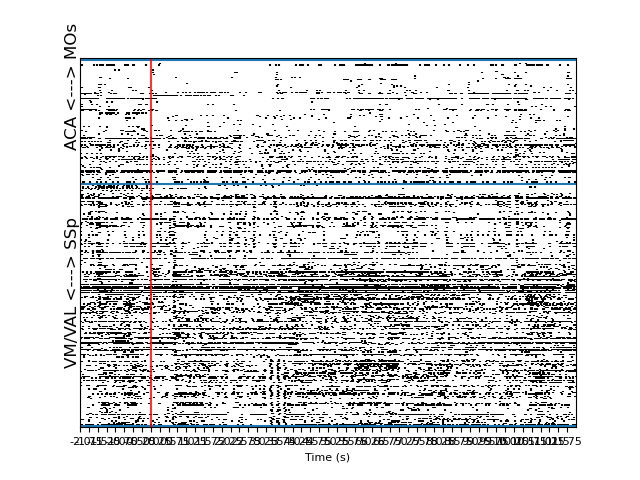

In [25]:
turn_on_xlabels = True
# ylabel_depth = True

fig, ax = plt.subplots() # figsize=(5,2.5)
ii = 0
for probei in probe_plot_order:
    unit_data = probe_unit_data[probei]
    
    for indi, spikes in enumerate(units_raster[probei]):
        ax.eventplot([spikes], lineoffsets=indi+ii, linelengths=0.95, color='black')
    ax.axhline(indi + ii + 1)
    ax.annotate(
        regions[probei],
#         '{:s}\nventral <-> dorsal'.format(regions[probei]),
        xy=(0, np.mean([ii, indi+ii])),
        xycoords='axes points',
        horizontalalignment='right',
        verticalalignment='center',
        rotation='vertical'
    )
    ii = indi + ii + 2

## Y labels
ax.axhline(-1)
ax.set_ylim([-2, ii+1])
plt.tick_params(axis='y', left=False, labelleft=False)

## X labels
ax.set_xlim([plot_time-plot_before, plot_time+plot_after])
if plot_event == 'stim':
    ax.axvline(plot_time, color='r', alpha=0.8)
if turn_on_xlabels:
    if plot_event == 'stim':
        ax.set_xticks(np.arange(plot_time-plot_before, plot_time+plot_after, 0.25))
        ax.set_xticklabels(np.arange(-plot_before, plot_after, 0.25), fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.set_xlabel('Time (s)', fontsize=8)
else:
    plt.tick_params(axis='x', labelbottom=False)